In [1]:
"""
Script written by Andrew Rohne. This validates the at-work subtour frequency for Met Council

Needs: 
  1: Visualizer Survey folder - reads one of the CSVs
  2: ActivitySim tours output

How To Use:
  1: Set the project_dir (cell 2) to the base of your project - this should include the visualizer summary inputs and the model data
  2: Set the output folder (where some CSV files are saved)
  2: Fix the census_auto_ownership_file (text should be relative to project_dir)
  3: Fix the hh file (again, should be relative to project_dir)
  4: You'll probably need to update some fields

"""

import sys
import pandas as pd
import os
import numpy as np
import time
import datetime
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

from simpledbf import Dbf5

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2022\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\SPA_Inputs'
SPA_OUTPUT = r'E:\Met_Council\survey_data\Phase2\SPA_Processed'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
SKIM_PATH = r'E:\Met_Council\metc-asim-model\Base_2022\OMX\allskims_M.omx'
SKIM_TABLE = 'SOV_DIST_M__MD'

# The sample rate needs to relate to how much of the model HHs are run compared to the total
# number of HHs.
SAMPLE_RATE = 0.20767 # 100000.0 / 1527646.0

DAMPING = 0.75

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

SPA_AWST_TOURPURP = {0: 'home', 1: 'business', 2: 'maint', 3: 'maint', 4: 'maint', 5: 'eat', 6: 'maint', 7: 'eat', 8: 'maint', 9: 'visit', 10: 'business'}

alt_coef = {
  'business1': 'coefficient_at_work_sub_tour_alternative_specific_constant_business1',
  'business2': 'coefficient_at_work_sub_tour_alternative_specific_constant_business2',
  'eat': 'coefficient_at_work_sub_tour_alternative_specific_constant_eat',
  'eat_business': 'coefficient_at_work_sub_tour_alternative_specific_constant_eat_business',
  'maint': 'coefficient_at_work_sub_tour_alternative_specific_constant_maint',
  'no_subtours': 'coefficient_at_work_sub_tour_alternative_specific_constant_no_subtours'
}

tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))

asim_subtours = tours.groupby('atwork_subtour_frequency').agg(z_asim_tours = ('atwork_subtour_frequency', 'count')) / SAMPLE_RATE

survey_day_weights = pd.read_csv(r'E:\Met_Council\survey_data\Phase2\weights\day_weights.csv')
survey_trip_weights = pd.read_csv(r'E:\Met_Council\survey_data\Phase2\weights\trip_weights.csv')

SQLalchemy is not installed. No support for SQL output.


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_11656\3661539409.py:61: DtypeWarning: Columns (16,28) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))


In [2]:
def get_awst_purp(x):
    #x = x[:-1] # cut off last trip, which should be returning to work
    _business_trips = 0
    _eat_trips = 0
    _maint_trips = 0
    for dp in [1, 2, 3, 4, 5, 9]:
        if dp in x.value_counts().keys():
            _business_trips += x.value_counts()[dp]
    for dp in [7]:
        if dp in x.value_counts().keys():
            _eat_trips += x.value_counts()[dp]
    for dp in [6, 8, 10]:
        if dp in x.value_counts().keys():
            _maint_trips += x.value_counts()[dp]
    if x.shape[0] == 1:
        return('eat') #assuming loop trip to get drive-thru
    elif _business_trips > 1 and _eat_trips > 0:
        return('eat_business')
    elif _eat_trips > 0:
        return('eat')
    elif _business_trips == 1:
        return('business1')
    elif _business_trips > 1:
        return('business2')
    else:
        return('maint')
        

In [3]:
spa_tours = {}
spa_trips = {}
for d in np.arange(1, 8):
    tour_input = pd.read_csv(os.path.join(SPA_OUTPUT, f"day{d}", "tours.csv"), low_memory=False)
    tour_input['day_id'] = tour_input['HH_ID'] * 10000 + tour_input['PER_ID'] * 100 + d
    spa_tours[d] = tour_input
    trip_input = pd.read_csv(os.path.join(SPA_OUTPUT, f"day{d}", "trips.csv"), low_memory=False)
    trip_input['day_id'] = trip_input['HH_ID'] * 10000 + trip_input['PER_ID'] * 100 + d
    trip_input['trip_id'] = trip_input['HH_ID'] * 100000 + trip_input['PER_ID'] * 1000 + trip_input['TRIP_ID']
    spa_trips[d] = trip_input

survey_tours = pd.concat(spa_tours).merge(survey_day_weights[['day_id', 'day_weight']], how = 'left', on = 'day_id')
survey_tours['day_weight'].fillna(0, inplace = True)
survey_tours[survey_tours['day_weight'] > 0]

survey_trips = pd.concat(spa_trips)
survey_trips = survey_trips.merge(survey_trip_weights[['trip_id', 'day_id', 'trip_weight']], how = 'left', on = ['trip_id', 'day_id'])


awst_trips = survey_trips[(survey_trips['SUBTOUR'] == 1)].groupby(['day_id', 'TOUR_ID']).agg(atwork_subtour_frequency = ('DEST_PURP', get_awst_purp), wtd_trips = ('trip_weight', 'sum')).reset_index()
work_st = survey_tours[survey_tours['TOURPURP'].isin([1, 10])].merge(awst_trips, how = 'left', on = ['day_id', 'TOUR_ID'])
work_st['atwork_subtour_frequency'].fillna('no_subtours', inplace = True)
awst_survey = work_st.groupby('atwork_subtour_frequency').agg(a_obs_tours = ('day_weight', 'sum'))

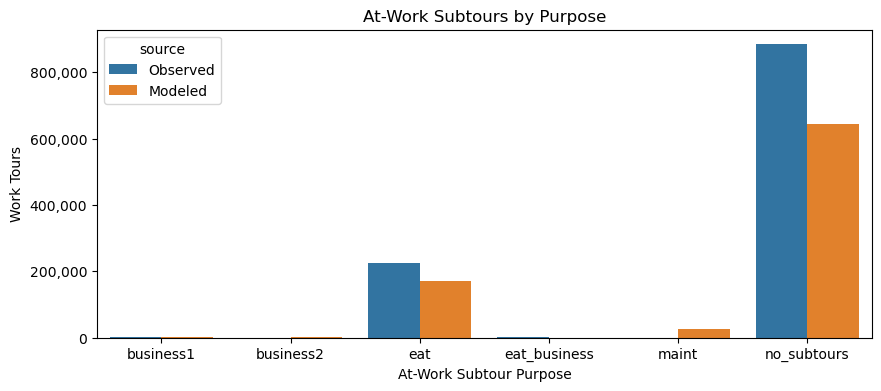

In [4]:
plot_data = awst_survey.join(asim_subtours, how = 'outer').reset_index().melt(id_vars = 'atwork_subtour_frequency', value_vars = ['a_obs_tours', 'z_asim_tours']).fillna(0)

fig = plt.figure(figsize=(10, 4))
plot_idx = 111
ax = plt.subplot(plot_idx)
source_dict = {'a_obs_tours': 'Observed', 'z_asim_tours': 'Modeled'}
plot_data['source'] = plot_data['variable'].map(source_dict)
sns.barplot(data = plot_data, x = 'atwork_subtour_frequency', y = 'value', hue = 'source')
plt.title(f"At-Work Subtours by Purpose")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Work Tours') 
plt.xlabel('At-Work Subtour Purpose')
plt.show()

,a_obs_tours,z_asim_tours
atwork_subtour_frequency,,
business1,0.001375,0.001545
business2,0.000000,0.001522
eat,0.202273,0.201406
eat_business,0.000240,0.000258
maint,0.000000,0.030492
no_subtours,0.796112,0.764778


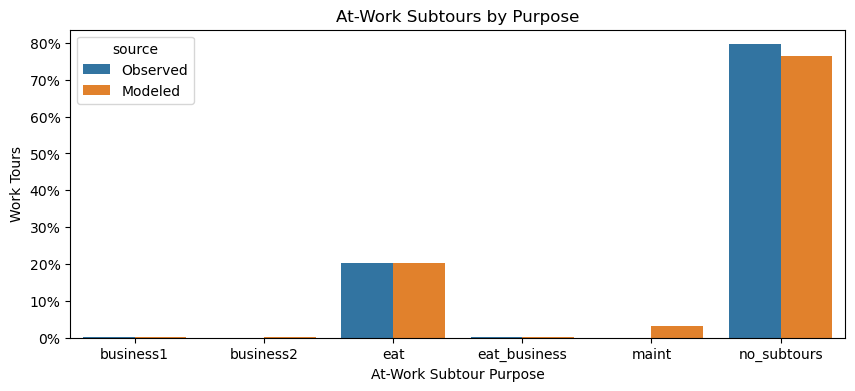

In [16]:
plot_data = awst_survey.join(asim_subtours, how = 'outer').fillna(0)
for c in plot_data.columns:
    plot_data[c] = plot_data[c] / plot_data[c].sum()
plot_data = plot_data.reset_index().melt(id_vars = 'atwork_subtour_frequency', value_vars = ['a_obs_tours', 'z_asim_tours']).fillna(0)

fig = plt.figure(figsize=(10, 4))
plot_idx = 111
ax = plt.subplot(plot_idx)
source_dict = {'a_obs_tours': 'Observed', 'z_asim_tours': 'Modeled'}
plot_data['source'] = plot_data['variable'].map(source_dict)
sns.barplot(data = plot_data, x = 'atwork_subtour_frequency', y = 'value', hue = 'source')
plt.title(f"At-Work Subtours by Purpose")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plt.ylabel('Work Tours') 
plt.xlabel('At-Work Subtour Purpose')
plt.show()

# Constant Updates

In [20]:
aswt_coefs = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH, "atwork_subtour_frequency_coefficients.csv"))

coef_update = awst_survey.join(asim_subtours, how = 'outer').fillna(0)
coef_update['pct_obs'] = coef_update['a_obs_tours'] / coef_update['a_obs_tours'].sum()
coef_update['pct_mod'] = coef_update['z_asim_tours'] / coef_update['z_asim_tours'].sum()
coef_update['coefficient_name'] = coef_update.index.map(alt_coef)
coef_update = coef_update.merge(aswt_coefs.rename(columns = {'value': 'old_value'}), how = 'left', on = 'coefficient_name')

coef_update['adjust'] = np.round(np.log(coef_update['pct_obs'] / coef_update['pct_mod'], where=coef_update['pct_obs']>0), 6) * DAMPING
coef_update.loc[coef_update['constrain'] == 'T', 'adjust'] = 0
coef_update['value'] = coef_update['old_value'] + coef_update['adjust']
coef_update

,a_obs_tours,z_asim_tours,pct_obs,pct_mod,coefficient_name,old_value,constrain,adjust,value
0,1527.369439,1396.446285,0.001375,0.001660,coefficient_at_work_sub_tour_alternative_speci...,-3.784679,F,-0.141288,-3.925967
1,0.000000,1266.432321,0.000000,0.001506,coefficient_at_work_sub_tour_alternative_speci...,-2.133700,F,0.000000,-2.133700
2,224646.384726,169735.638272,0.202273,0.201811,coefficient_at_work_sub_tour_alternative_speci...,1.063505,F,0.001714,1.065219
3,266.207980,245.581933,0.000240,0.000292,coefficient_at_work_sub_tour_alternative_speci...,-3.042990,F,-0.148015,-3.191005
4,0.000000,25535.705687,0.000000,0.030361,coefficient_at_work_sub_tour_alternative_speci...,-0.619800,F,0.000000,-0.619800
5,884168.808761,642880.531613,0.796112,0.764369,coefficient_at_work_sub_tour_alternative_speci...,0.000000,T,0.000000,0.000000


In [21]:
coef_update[['coefficient_name', 'a_obs_tours', 'z_asim_tours']].style.format({'a_obs_tours': "{:,.0f}", 'z_asim_tours': "{:,.0f}"})

,coefficient_name,a_obs_tours,z_asim_tours
0,coefficient_at_work_sub_tour_alternative_specific_constant_business1,"1,527","1,396"
1,coefficient_at_work_sub_tour_alternative_specific_constant_business2,0,"1,266"
2,coefficient_at_work_sub_tour_alternative_specific_constant_eat,"224,646","169,736"
3,coefficient_at_work_sub_tour_alternative_specific_constant_eat_business,266,246
4,coefficient_at_work_sub_tour_alternative_specific_constant_maint,0,"25,536"
5,coefficient_at_work_sub_tour_alternative_specific_constant_no_subtours,"884,169","642,881"


In [22]:
coef_update[['coefficient_name', 'value', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,value,constrain
coefficient_at_work_sub_tour_alternative_specific_constant_business1,-3.925967,F
coefficient_at_work_sub_tour_alternative_specific_constant_business2,-2.1337,F
coefficient_at_work_sub_tour_alternative_specific_constant_eat,1.0652187499999999,F
coefficient_at_work_sub_tour_alternative_specific_constant_eat_business,-3.191005,F
coefficient_at_work_sub_tour_alternative_specific_constant_maint,-0.6198,F
coefficient_at_work_sub_tour_alternative_specific_constant_no_subtours,0.0,T
